In [1]:
# from gensim.models import Word2Vec
import gensim.models.keyedvectors as word2vec
from sklearn.decomposition import PCA
from mpl_toolkits import mplot3d

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [2]:
model = word2vec.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [36]:
lyrics = 'We don\'t need no education us'
words = lyrics.split(' ')
pca = PCA(n_components=2)
# vectors = []

X = model[words]
word_embeddings = pca.fit_transform(model[words])

print(word_embeddings)

[[-1.0482818  -1.6985778 ]
 [ 2.2712185  -0.07831859]
 [-0.12603511  0.19059725]
 [ 0.31040075  0.5562284 ]
 [-1.1099597   1.778277  ]
 [-0.297343   -0.74820614]]


In [4]:
import numpy as np
def f(a, b):
    def eq(theta, phi):
        return np.sin(a * theta) + np.cos(b * phi)
    return eq

def plain(x, y):
    return x + y

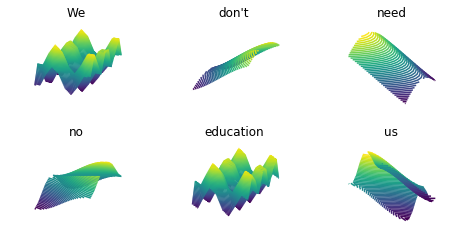

In [5]:
# fig = plt.figure()
fig = plt.figure(figsize=plt.figaspect(0.5))
# fig, axs = plt.subplots(nrows=3, ncols=6)

for i in range(word_embeddings.shape[0]):
    result = word_embeddings[i]
#     eq = plain
    if i == 1: eq = f(0.2, 0.2)
    else: eq = f(result[0], result[1])
    x = np.linspace(-5, 5, 10)
    y = np.linspace(-5, 5, 10)
    
    X, Y = np.meshgrid(x, y)
    Z = eq(X, Y)

    # for ax in axs.flat:
    ax = fig.add_subplot(2, 3, i + 1, projection='3d')
    ax.contour3D(X, Y, Z, 50, cmap='viridis')
    ax.set_title(words[i])
    ax.axis('off')

In [6]:
z = np.load('z.npy')
z2 = pca.fit_transform(z[0])
print(z2.shape)
z2 /= np.max(z2)
z2[0]

(7531, 2)


array([ 0.9980616 , -0.03740425], dtype=float32)

In [53]:
fps = 100

# words to duration
durations = [3 * fps, 5 * fps]
n_frames = sum(durations)
# nf_transition = lin.shape[0]

Zs = np.zeros((30, 30, sum(durations)))
x = np.linspace(-6, 6, 30)
y = np.linspace(-6, 6, 30)
X, Y = np.meshgrid(x, y)

padding = 6

def interp(r1, r2, nfr=50):
    return np.linspace(r1, r2, nfr)
    
start = 0
end = 0
for i in range(1, len(durations)):
    src_dur = durations[i - 1]
    src = word_embeddings[i - 1]
    dst = word_embeddings[i]

    transition = interp(src, dst, nfr=padding)

    start = end
    end += src_dur - padding // 2
  
    print(start, end)
    # word
    for k in range(start, end):
        eq = f(src[0] + z2[k][0], src[1] + z2[k][1])
        Zs[:, :, k] = eq(X, Y)

    # transition
    for j, fr in enumerate(transition):
        x = fr[0] + z2[end + j][0]
        y = fr[1] + z2[end + j][1]
        eq = f(x, y)
        Zs[:, :, end + j] = eq(X, Y)

    end += len(transition)
    print(end)


for i in range(end, end + 500 - padding // 2):
    eq = f(dst[0] + z2[i][0], dst[1] + z2[i][1])
    Zs[:, :, i] = eq(X, Y)

def update_plot(i, Z, plot):
    plot[0].remove()
    plot[0] = ax.plot_surface(X, Y, Zs[:,:,i], cmap="magma")
    ax.axis('off')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
print(Zs.shape)
plot = [ax.plot_surface(X, Y, Zs[:,:,0], color='0.75', rstride=1, cstride=1)]
ani = animation.FuncAnimation(fig, update_plot, n_frames, fargs=(Zs, plot), interval=1000 / fps)


KeyError: 0

nframes: 1150
(10, 10, 1150)


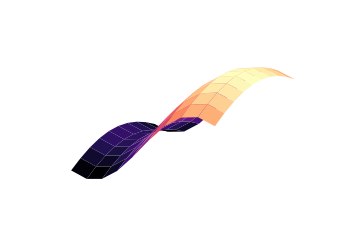

In [74]:
import tagger
from scipy import signal
import importlib

importlib.reload(tagger)
limit = 5
resolution = 10
fps = 100
lyrics = ['We', 'don\'t', 'need', 'no', 'education']

pca = PCA(n_components=2)

# in seconds
durations = [('', 2.8),
             ('We', 0.4),
             ('don\'t', 0.4),
             ('need', 0.6),
             ('no', 1),
             ('education', 2),
             ('', 4.3)]


nframes = int(tagger.get_frames(durations, fps))
print("nframes: {}".format(nframes))

word_embeddings_orig = pca.fit_transform(model[lyrics])
word_embeddings = {}

# print(word_embeddings_orig)
for i, word in enumerate(lyrics):
    if word != '':
        word_embeddings[word] = word_embeddings_orig[i]

# noise from wav embedding
z = np.load('sample_z.npy')
wav_embeddings_orig = pca.fit_transform(z[0]) / np.max(z[0])
wav_embeddings = signal.resample(wav_embeddings_orig, nframes) * 2e-1

x = np.linspace(-limit, limit, resolution)
X, Y = np.meshgrid(x, x)

# frames of animation
Zs = tagger.get_Zs(word_embeddings, durations, wav_embeddings, resolution, nframes, limit, fps)
# print(Zs[:, :, -1])

def update_plot(i, Z, plot):
    plot[0].remove()
    plot[0] = ax.plot_surface(X, Y, Zs[:,:,i], cmap="magma")
    ax.axis('off')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
print(Zs.shape)
plot = [ax.plot_surface(X, Y, Zs[:,:,0], color='0.75', rstride=1, cstride=1)]
ani = animation.FuncAnimation(fig, update_plot, frames=n_frames, fargs=(Zs, plot), interval=10)

In [50]:
# import imagemagick
# ani.save('we-dont-250.gif',writer='imagemagick',fps=fps)
ani.save('we-dont.mp4',writer='ffmpeg',fps=fps)

In [75]:
plt.rcParams['animation.html'] = 'html5'
ani

In [4]:
from pydub import AudioSegment

sound = AudioSegment.from_mp3("pink_floyd.mp3")

duration = 11.5 * 1000

part = sound[:duration]
part.export('sample.mp3', format='mp3')



<_io.BufferedRandom name='sample.mp3'>

In [55]:
z = np.load('sample_z.npy')

wav_embeddings_orig = pca.fit_transform(z[0]) / np.max(z[0])

wav_embeddings = signal.resample(wav_embeddings_orig, 1150)

# print(wav_embeddings_orig[:3])

# print(wav_embeddings[:10])

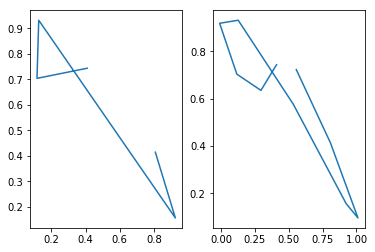

In [54]:
a = np.random.rand(5, 2)

b = signal.resample(a, 10)


plt.subplot(1, 2, 1)
plt.plot(a[:, 0], a[:, 1])
plt.subplot(1, 2, 2)
plt.plot(b[:, 0], b[:, 1])